In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive


In [6]:
ls

deeplearning001/  DL/  inception/  inception.ipynb  vgg/


In [28]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
import numpy as np
from keras.layers import Dense, Dropout
from keras.layers import GlobalAveragePooling2D
from keras.models import Model,model_from_json
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import keras


In [0]:
np.random.seed(3)
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        k = len(self.losses)
        if(k!=0):
            self.losses.append((logs.get('loss')+self.losses[k-1]*k)/(k+1))
        else:
            self.losses.append(logs.get('loss'))


DATA_DIR = "/content/drive/DL/small"

In [15]:
train_datagen = ImageDataGenerator().flow_from_directory(directory=DATA_DIR+"//"+"train",target_size=(224,224),color_mode='rgb',
                                                         classes=["AK","FR","Noise","SGV", "SK","SM", "SP"],class_mode="categorical", batch_size=32)

Found 14387 images belonging to 7 classes.


In [31]:
val_datagen = ImageDataGenerator().flow_from_directory(directory=DATA_DIR+"//"+"val",target_size=(224,224),color_mode='rgb',
                                                       classes=["AK","FR","Noise","SGV", "SK","SM", "SP"], class_mode="categorical",batch_size=32)
test_datagen = ImageDataGenerator().flow_from_directory(directory=DATA_DIR+"//"+"test",target_size=(224,224),color_mode='rgb',
                                                        classes=["AK","FR","Noise","SGV", "SK","SM", "SP"], class_mode="categorical",batch_size=32)

Found 1780 images belonging to 7 classes.
Found 1811 images belonging to 7 classes.


In [0]:
base_model = VGG16(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(7, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

In [32]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [19]:
model.compile(optimizer='adam', metrics=['accuracy'],loss='categorical_crossentropy')
history = LossHistory()

# train the model on the new data for a few batches

loss_acc = model.fit_generator(generator=train_datagen,validation_data=val_datagen,epochs=5,callbacks=[history])

Epoch 1/5
450/450 [==============================] - 164s 365ms/step - loss: 0.4433 - acc: 0.9055 - val_loss: 0.0121 - val_acc: 0.9983
Epoch 2/5
261/450 [================>.............] - ETA: 1:00 - loss: 0.0597 - acc: 0.9825450/450 [==============================] - 163s 363ms/step - loss: 0.0515 - acc: 0.9851 - val_loss: 0.0042 - val_acc: 0.9994
Epoch 3/5
392/450 [=========================>....] - ETA: 18s - loss: 0.0308 - acc: 0.9908450/450 [==============================] - 163s 363ms/step - loss: 0.0308 - acc: 0.9912 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 4/5
441/450 [============================>.] - ETA: 2s - loss: 0.0293 - acc: 0.9910450/450 [==============================] - 164s 365ms/step - loss: 0.0289 - acc: 0.9911 - val_loss: 0.0018 - val_acc: 0.9994
Epoch 5/5
450/450 [==============================] - 163s 363ms/step - loss: 0.0234 - acc: 0.9934 - val_loss: 0.0016 - val_acc: 0.9994


In [33]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [24]:
model_json = model.to_json()
with open("/content/drive/DL/model_vgg.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/DL/model_vgg.h5")
print("Saved model to disk")


Saved model to disk


In [34]:
json_file = open('/content/drive/DL/model_vgg.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/DL/model_vgg.h5")
print("Loaded model from disk")


loaded_model.compile(optimizer='adam', metrics=['accuracy'],loss='categorical_crossentropy')

preds = loaded_model.evaluate_generator(test_datagen)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

Loaded model from disk
Loss = 0.0027292892307195166
Test Accuracy = 0.9988956377691883


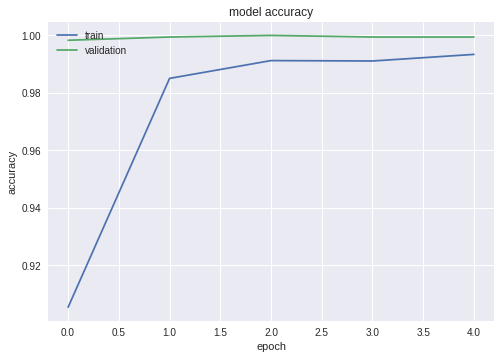

In [35]:
# summarize history for accuracy
plt.plot(loss_acc.history['acc'])
plt.plot(loss_acc.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

<function matplotlib.pyplot.show>

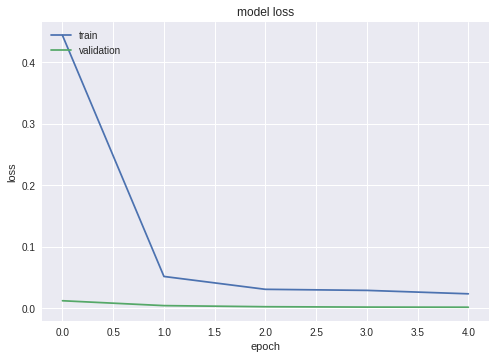

In [36]:
plt.plot(loss_acc.history['loss'])
plt.plot(loss_acc.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show

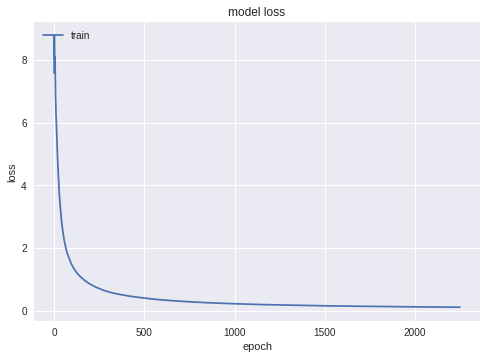

In [37]:
plt.plot(history.losses)

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()